# Final Assignment - AccessViz - AutoGIS 2018 
##### Name: Ella Rauth 
##### Student ID: 014964527

## Importing Packages and Data

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import folium 
import matplotlib.pyplot as plt
import os.path

In [2]:
# reading the grid file
grid = gpd.read_file('data/grid/MetropAccess_YKR_grid_EurefFIN.shp')

# saving the YKR_IDs in grid as a list
ykr_ids = list(grid.YKR_ID)

In [3]:
# list of valid travel modes
travel_modes = ['walk_t', 'walk_d', 'bike_f_t', 'bike_s_t', 'bike_d', 'pt_r_tt', 'pt_r_t', 'pt_r_d', 
                'pt_m_tt', 'pt_m_t', 'pt_m_d', 'car_r_t', 'car_r_d', 'car_m_t', 'car_m_d', 'car_sl_t']

# global variables for storing the output of the user defined input
valid_ids = [] # list of valid YKR-IDs specified by the user
ttmats = [] # list of travel time matrices corresponding to the valid ids
joined_ttmats = [] # list of travel time matrices that have been joined with the grid

# function for clearing the valid_ids, ttmats, and joined_ttmats lists
def clear_all():
    valid_ids.clear()
    ttmats.clear()
    joined_ttmats.clear()

# function for determining the indices of ykr-ids in the valid_ids list
def indices_of_ids(input_ids):
    input_ids_indices = []
    
    # determining the index of each id in input_ids and adding it to the input_ids_indices list
    for i in input_ids:
        input_ids_indices.append(valid_ids.index(i)) 
    
    return input_ids_indices

In [18]:
# function for checking whether an output folder exists, and creating it if not
def check_folder(output_folder):
    # check if the specified output folder exists
    if not os.path.isdir(output_folder):
        # if the folder does not exist, create it
        os.makedirs(output_folder)
        
# function for checking if the input ids of a function have been loaded
def check_input_ids(input_ids):
    for i in input_ids:
        assert i in valid_ids, 'One of the IDs you chose has not been loaded (ID: '+str(i)+'), please go back to functionality 1 and add it to the list of IDs to load!'
    
# function for checking whether a specified travel mode is valid
def check_travel_modes(travel_mode):
    assert travel_mode in travel_modes, 'Please select a valid travel mode! '+str(travel_modes)

# function for checking whether a file has already been saved, and saving it if not
def check_and_save(output_file, output_file_name):
    # checking if the file has already been saved
    if not os.path.isfile(output_file_name):
        # saving the file
        output_file.to_file(output_file_name)

## NoData Values
Notice that there are NoData values present in the data (value -1). In such cases the result cell should always end up having a value -1 when doing travel mode comparisons. In the visualizations, the NoData values should be removed before visualizing the map.

## Functionality 1
AccessViz finds from the data folder all the matrices that user has specified by assigning a list of integer values that should correspond to YKR-IDs found from the attribute table of a Shapefile called MetropAccess_YKR_grid.shp. If the ID-number that the user has specified does not exist in the data folders, the tools should warn about this to the user but still continue running. The tool should also inform the user about the execution process: tell the user what file is currently under process and how many files there are left (e.g. “Processing file travel_times_to_5797076.txt.. Progress: 3/25”).

In [5]:
# function for loading the travel time matrices for a set of YKR_IDs that were specified by the user
def load_ttmats(input_ids=[]):    
    # empty lists with travel matrices and ids
    clear_all()
    
    # intitializing a counter for processed ids
    done = 0
    
    # matching the input_ids with the ykr_ids and loading the corresponding travel time matrices
    for i in input_ids:        
        if i in ykr_ids: # the current id is a valid YKR-ID
            if i not in valid_ids: # the current id has not yet been processed
                # adding the current id to the list of valid ids
                valid_ids.append(i)
                
                # reading the travel time matrix
                ttmat = pd.read_csv('data/matrices/travel_times_to_'+str(i)+'.txt', sep=';')

                # converting the ttmat dataframe to a geodataframe
                ttmat = gpd.GeoDataFrame(ttmat)

                # setting the crs to that of the grid geodataframe
                ttmat.crs = grid.crs
                
                # loading the file corresponding to the id and adding it to the ttmats list
                ttmats.append(ttmat)
            
            # incrementing the counter of processed ids
            done += 1
            
            # informing the user about the progress
            print('STATUS:\t Loaded file travel_times_to_'+str(i)+'.txt',
                  'Progress:', str(done)+'/'+str(len(input_ids))+' IDs processed')
                        
        else: # the current id is not a valid YKR-ID
            # incrementing the counter of processed ids
            done += 1
            
            # informing the user about the progress
            print('WARNING:', i, 'is not a valid YKR-ID', 
                  '\t\t Progress:', str(done)+'/'+str(len(input_ids))+' IDs processed')           

##### Testing the function for loading the travel time matrices of selected YKR_IDs

In [6]:
# user defined list of YKR_IDs
input_ids = [5793260, 5793469, 5990002, 6015143]

# loading the travel time matrices for the above specified input
load_ttmats(input_ids)

STATUS:	 Loaded file travel_times_to_5793260.txt Progress: 1/4 IDs processed
STATUS:	 Loaded file travel_times_to_5990002.txt Progress: 3/4 IDs processed
STATUS:	 Loaded file travel_times_to_6015143.txt Progress: 4/4 IDs processed


## Functionality 2

AccessViz can create Shapefiles from the chosen Matrix text tables (e.g. travel_times_to_5797076.txt) by joining the Matrix file with MetropAccess_YKR_grid Shapefile where from_id in Matrix file corresponds to YKR_ID in the Shapefile. The tool saves the result in the output-folder that user has defined. You should name the files in a way that it is possible to identify the ID from the name (e.g. 5797076).

In [7]:
# function for processing the travel time matrices for the valid ids
def join_ttmats(output_folder):
    # checking if the specified output folder exists and if not, creating it
    check_folder(output_folder)
    
    # joining each ttmat with the grid 
    for i in range(len(valid_ids)):
        # checking if the join result has already been calculated
        if len(valid_ids) != len(joined_ttmats):
            # joining the current travel time matrix with the grid file on from_id and YKR_ID
            joined_ttmats.append(ttmats[i].merge(grid, left_on='from_id', right_on='YKR_ID'))

        # creating the file name
        output_file_name = output_folder + '/joined_travel_times_to_' + str(valid_ids[i]) + '.shp'
                
        # saving the file           
        check_and_save(joined_ttmats[i], output_file_name)
            
        # informing the user about the progress
        print('STATUS:\t Saved the join result for YKR-ID ', str(valid_ids[i]),
              'Progress:', str(i+1)+'/'+str(len(valid_ids)), 'YKR-IDs processed')

##### Testing the function for joining the travel time matrices with the grid file

In [8]:
# specifying the output folder
output_folder = 'output/join_results'

# joining the previously loaded travel time matrices with the grid file
join_ttmats(output_folder)

STATUS:	 Saved the join result for YKR-ID  5793260 Progress: 1/3 YKR-IDs processed
STATUS:	 Saved the join result for YKR-ID  5990002 Progress: 2/3 YKR-IDs processed
STATUS:	 Saved the join result for YKR-ID  6015143 Progress: 3/3 YKR-IDs processed


## Functionality 3

AccessViz can visualize the travel times of selected YKR_IDs based on the travel mode that the user specifies. It can save those maps into a folder that user specifies. The output maps can be either static or interactive and user can choose which one with a parameter. You can freely design yourself the style of the map, colors, travel time intervals (classes) etc. Try to make the map as informative as possible!

In [9]:
# function for visualizing a static map
def static_map(ykr_id, ttmat, travel_mode, output_folder):
    # reprojecting the ttmat to EPSG 3857
    ttmat = ttmat.to_crs(epsg=3857)

    # creating the map
    ttmat_map = ttmat.plot(column=travel_mode, cmap='YlOrRd', legend=True, alpha=0.85, figsize=(15, 15))
    
    # adding a title to the map
    ttmat_map.set_title('Travel Times from YKR-ID '+str(ykr_id)+' in Minutes')

    # adding a basemap
    ctx.add_basemap(ttmat_map)

    # creating a figure out of the plot
    ttmat_map = ttmat_map.get_figure()
    
    # creating the file name
    output_file_name = output_folder+'/static_map_travel_times_to_'+str(ykr_id)+'_'+travel_mode+'.png'

    # saving the map in the specified folder
    ttmat_map.savefig(output_file_name)

In [10]:
# function for visulaizing an interactive map
def interactive_map(ykr_id, ttmat, travel_mode, output_folder):
    # reprojecting the ttmat to EPSG 4326
    ttmat = ttmat.to_crs(epsg=4326)

    # creating a geoid column for folium
    ttmat['geoid'] = ttmat.index.astype(str)

    # dropping all unneccesary columns
    ttmat = ttmat[['geoid', travel_mode, 'geometry']]

    # creating a folium map with initial focus on Helsinki
    ttmat_map = folium.Map(location=[60.25, 24.8], zoom_start=10, control_scale=True)

    # adding a choropleth layer of the travel times
    ttmat_map.choropleth(geo_data=ttmat.to_json(), data=ttmat, columns=['geoid', travel_mode],
                         key_on='feature.id', fill_color='YlOrRd', fill_opacity=0.85, line_weight=0, 
                         legend_name='Travel Times from YKR-ID '+str(ykr_id)+' in Minutes')

    # creating the file name
    output_file_name = output_folder+'/interactive_map_travel_times_to_'+str(ykr_id)+'_'+travel_mode+'.html'

    # saving the map in the specified folder
    ttmat_map.save(output_file_name)  

In [11]:
# function for visualizing travel times of the selected travel time matrices, 
# given a travel mode, a map type (static or interactive), and an output folder name
def visualize_ttmats(travel_mode, map_type, output_folder, input_ids=[]):
    # checking if the input ids have been loaded
    check_input_ids(input_ids)
    
    # assert that the travel mode is valid
    check_travel_modes(travel_mode)
    
    # checking that the map type is valid
    assert map_type in ['static', 'interactive'], 'Please select a valid map type! [\'static\', \'interactive\']'
        
    # checking if the specified output folder exists and if not, creating it
    check_folder(output_folder)
    
    # creating a list with the indices of the input ids in the valid_ids list
    input_ids_indices = indices_of_ids(input_ids)
        
    # intitializing a counter for processed ids
    done = 0
    
    # for each (index of each) input id
    for i in input_ids_indices:
        # saving the current travel time matrix in a new variable
        ttmat = joined_ttmats[i]
        
        # removing rows with missing values in the travel mode column
        ttmat = ttmat[ttmat[travel_mode] != -1]
                
        if map_type == 'static': # the user specified 'static' as the map type
            static_map(valid_ids[i], ttmat, travel_mode, output_folder)
            
        else: # the user specified 'interactive' as the map type
            interactive_map(valid_ids[i], ttmat, travel_mode, output_folder)     
            
        # updating the counter
        done += 1
        
        # informing the user about the progress
        print('STATUS:\t Saved the map for YKR-ID ', str(valid_ids[i]),
              'Progress:', str(done)+'/'+str(len(input_ids)), 'YKR-IDs processed')

##### Testing the function for visualizing travel times (static maps)

STATUS:	 Saved the map for YKR-ID  5793260 Progress: 1/2 YKR-IDs processed
STATUS:	 Saved the map for YKR-ID  5990002 Progress: 2/2 YKR-IDs processed


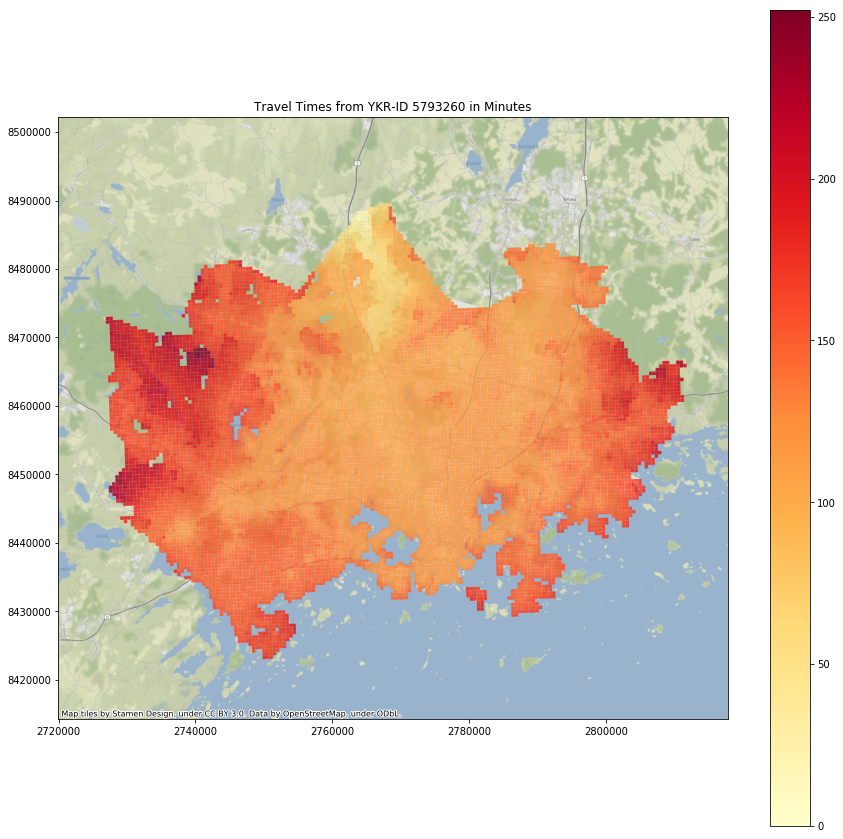

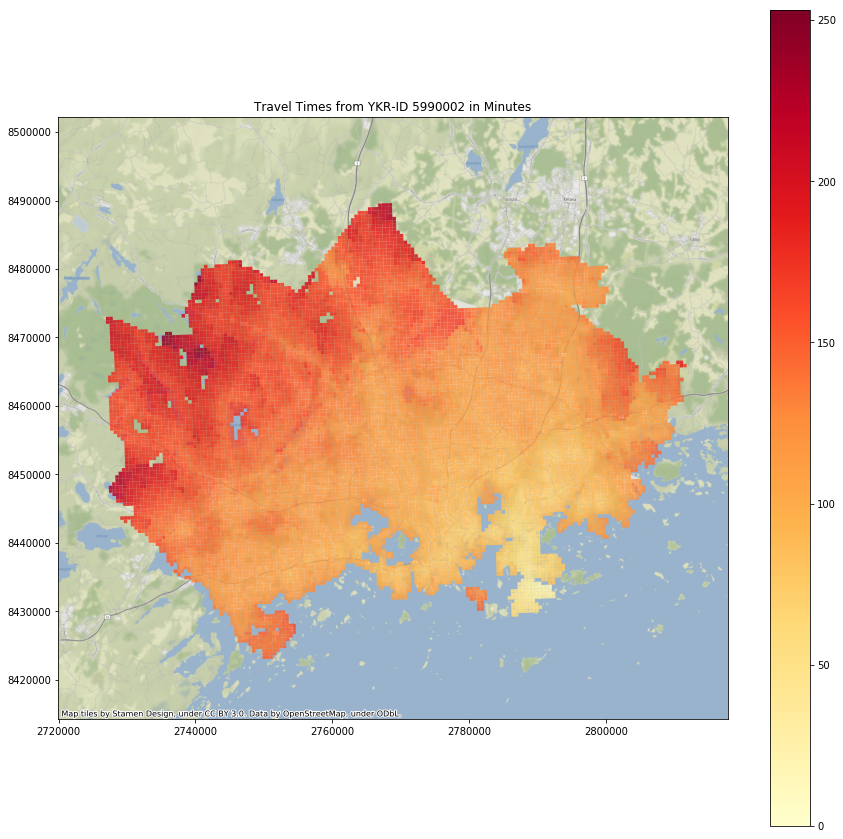

In [12]:
# selecting a subset of IDs for which to create the map
input_ids = [5793260, 5990002]

# selecting a travel mode
travel_mode = 'pt_m_tt'

# selecting a map type from: 'static', 'interactive'
map_type = 'static'

# selecting an output folder
output_folder = 'output/maps'

# creating some static maps for travelling by car
visualize_ttmats(travel_mode, map_type, output_folder, input_ids)

##### Testing the function for visualizing travel times (interactive maps)

In [13]:
# selecting a subset of IDs for which to create the map
input_ids = [5990002, 6015143]

# selecting a travel mode from: 'walk', 'pt', and 'car'
travel_mode = 'car_r_t'

# selecting a map type from: 'static', 'interactive'
map_type = 'interactive'

# selecting an output folder
output_folder = 'output/maps'

# creating some static maps for travelling by car
visualize_ttmats(travel_mode, map_type, output_folder, input_ids)

STATUS:	 Saved the map for YKR-ID  5990002 Progress: 1/2 YKR-IDs processed
STATUS:	 Saved the map for YKR-ID  6015143 Progress: 2/2 YKR-IDs processed


## Functionality 4

AccessViz can also compare travel times or travel distances between two different travel modes (more than two travel modes are not allowed). Thus IF the user has specified two travel modes (passed in as a list) for the AccessViz, the tool will calculate the time/distance difference of those travel modes into a new data column that should be created in the Shapefile. The logic of the calculation is following the order of the items passed on the list where first travel mode is always subtracted by the last one: travelmode1 - travelmode2. The tool should ensure that distances are not compared to travel times and vice versa. If the user chooses to compare travel modes to each other, you should add the travel modes to the filename such as Accessibility_5797076_pt_vs_car.shp. If the user has not specified any travel modes, the tool should only create the Shapefile but not execute any calculations. It should be only possible to compare two travel modes between each other at the time. Accepted travel modes are the same ones that are found in the actual TravelTimeMatrix file (pt_r_tt, car_t, etc.). If the user specifies something else, stop the program, and give advice what are the acceptable values.

In [17]:
# function for comparing travel times/distances for two different travel modes
def compare_travel(output_folder, input_ids = [], travel_modes=[]):    
    # checking if the input ids have been loaded
    check_input_ids(input_ids)
    
    # checking if no more than 2 travel modes were specified
    assert len(travel_modes) <= 2, 'Please do not select more than two travel modes!'
    
    # checking if the travel modes are valid
    for travel_mode in travel_modes: 
        check_travel_modes(travel_mode)
        
    # checking if the specified output folder exists and if not, creating it
    check_folder(output_folder)
        
    # creating a list with the indices of the input ids in the valid_ids list
    input_ids_indices = indices_of_ids(input_ids)
        
    # determining the amount of travel modes passed
    if len(travel_modes) == 2: # two travel modes were passed for comparison
        # check that both travel modes are time or both are distance
        assert travel_modes[0][-1] == travel_modes[1][-1], 'You are trying to compare travel time to distance, this is not allowed. Please review the list of transportation modes!'
        
        # creating the new column name
        comp_name = str(travel_modes[0])+'_vs_'+str(travel_modes[1])
        
        # intitializing a counter for processed ids
        done = 0
        
        for i in input_ids_indices:            
            # copying the travel matrix for the current id into a new variable
            output = joined_ttmats[i]            
            
            # creating the new column with the compared times/distances
            output[comp_name] = output[travel_modes[0]] - output[travel_modes[1]]
            
            # creating the file name
            output_file_name = output_folder+'/comparison_'+str(valid_ids[i])+'_'+comp_name+'.shp'
                                   
            # saving the file           
            check_and_save(output, output_file_name)
                
            # updating the counter
            done += 1
                
            # informing the user about the progress
            print('STATUS:\t Saved the travel mode comparison of', comp_name, 'for YKR-ID ', str(valid_ids[i]),
                  'Progress:', str(done)+'/'+str(len(input_ids)), 'YKR-IDs processed')
            
    else: # less than 2 travel modes were given
        # intitializing a counter for processed ids
        done = 0
        
        for i in input_ids_indices:
            # creating the file name
            output_file_name = output_folder+'/no_comparison_'+str(valid_ids[i])+'.shp'
                
            # saving the file           
            check_and_save(joined_ttmats[i], output_file_name)
                
            # updating the counter
            done += 1
            
            # informing the user about the progress
            print('STATUS:\t Saving the travel time matrix for YKR-ID ', str(valid_ids[i]),
                  'Progress:', str(done)+'/'+str(len(input_ids)), 'YKR-IDs processed')

##### Testing the function for comparing travel modes (with YKR-IDs specified)

In [15]:
# selecting a subset of IDs for which to create the map
input_ids = [5793260, 5990002]

# selecting two travel modes
modes = ['walk_t', 'bike_s_t']

# selecting an output folder
output_folder = 'output/travel_mode_comparisons'

# comparing the travel modes
compare_travel(output_folder, input_ids, modes)

STATUS:	 Saved the travel mode comparison of walk_t_vs_bike_s_t for YKR-ID  5793260 Progress: 1/2 YKR-IDs processed
STATUS:	 Saved the travel mode comparison of walk_t_vs_bike_s_t for YKR-ID  5990002 Progress: 2/2 YKR-IDs processed


##### Testing the function for comparing travel modes (without YKR-IDs specified)

In [16]:
# selecting a subset of IDs for which to create the map
input_ids = [6015143]

# selecting an output folder
output_folder = 'output/travel_mode_comparisons'

# comparing the travel modes
compare_travel(output_folder, input_ids)

STATUS:	 Saving the travel time matrix for YKR-ID  6015143 Progress: 1/1 YKR-IDs processed


## Functionality 5

(option 1). Bundled with AccessViz there is also a separate interactive map that shows the YKR grid values in Helsinki region. The purpose of the map is to help the user to choose the YKR-IDs that s/he is interested to visualize / analyze.

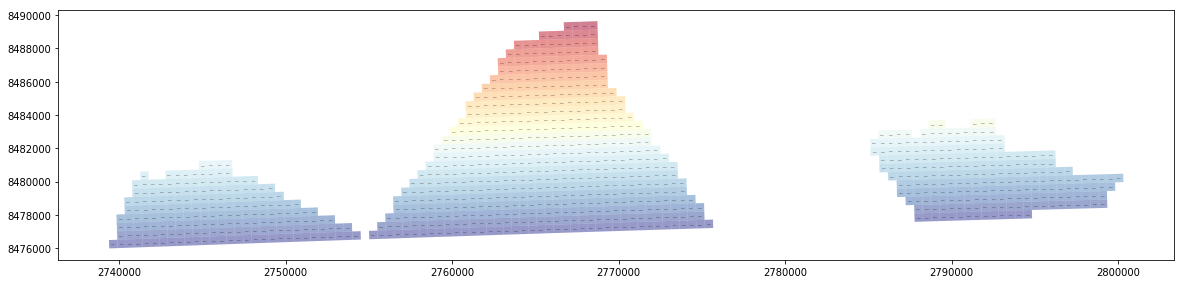

In [26]:
# creating the map
ttmat_map = test[0:1000].plot(column='from_id', cmap='RdYlBu', alpha=0.5)

for i in range(len(test[0:1000])):
    coords = test['center'][i]
    ttmat_map.text(coords.x, coords.y, str(test['from_id'][i]), fontsize=1, ha="center", va="center")

# adding a basemap
# ctx.add_basemap(ttmat_map)

# creating a figure out of the plot
ttmat_map = ttmat_map.get_figure()

# setting the size of the figure
ttmat_map.set_size_inches(20, 20)

folium.Map

In [15]:
test.head(3)

,from_id,to_id,walk_t,walk_d,bike_s_t,bike_f_t,bike_d,pt_r_tt,pt_r_t,pt_r_d,...,car_r_t,car_r_d,car_m_t,car_m_d,car_sl_t,x,y,YKR_ID,geometry,center
0,5785640,5793260,57,3994,16,10,3638,57,57,3994,...,11,4314,10,4314,9,381875.0,6697880.0,5785640,"POLYGON ((382000.0001388059 6697750.000128186,...",POINT (381875.0001388298 6697875.000128166)
1,5785641,5793260,60,4200,37,23,8619,60,60,4200,...,16,4524,15,4524,12,382125.0,6697880.0,5785641,"POLYGON ((382250.00013875 6697750.000128181, 3...",POINT (382125.0001387748 6697875.000128158)
2,5785642,5793260,62,4318,37,23,8619,62,62,4318,...,16,8986,15,8986,12,382375.0,6697880.0,5785642,"POLYGON ((382500.0001386951 6697750.000128172,...",POINT (382375.0001387197 6697875.000128153)


In [17]:
test = joined_ttmats[0].to_crs(epsg=3857)
test['center'] = test['geometry'].centroid
test_point = test['center'][0]
print(test_point.x)
print(test_point.y)

2766961.0916547193
8489323.640798526


## Functionality 6

(option 2). AccessViz can also visualize the travel mode comparisons that were described in step 4. You can design the style of the map yourself, but try to make it as informative as possible!

In [19]:
# function for visualizing travel mode comparisons
def visualize_travel_comparison(input_folder, output_folder, map_type, input_ids=[], travel_modes=[]):     
    # checking if exactly 2 travel modes were specified
    assert len(travel_modes) == 2, 'Please select exactly two travel modes!'
            
    for i in input_ids: 
        # creating the name the travel mode comparison shape file would have
        file_name = input_folder+'/comparison_'+str(i)+'_'+str(travel_modes[0])+'_vs_'+str(travel_modes[1])+'.shp'
        
        # checking if the file has already been created
        if not os.path.isfile(file_name):
            # and creating it if it hasn't been created
            compare_travel(output_folder, i, travel_modes)
            
        # loading the file of the travel mode comparison
        comparison_file = gpd.read_file(file_name)
        
        # visualizing the travel mode comparison
        visualize_ttmats(travel_mode, map_type, output_folder, i) 

## Functionality 7

(option 3). AccessViz can also visualize shortest path routes (walking, cycling, and/or driving) using OpenStreetMap data from Helsinki Region. The impedance value for the routes can be distance (as was shown in Lesson 7) or time (optional for the most advanced students). This functionality can also be a separate program (it is not required to bundle include this with the rest of the AccessViz tool)